In [1]:
import pandas as pd
import glob
import csv
import numpy as np
from collections import Counter
from PIL import Image
import os
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.metrics import classification_report, confusion_matrix, precision_score,recall_score,f1_score, roc_curve, roc_auc_score, matthews_corrcoef
import time
import cv2
import copy
from tqdm.auto import tqdm
import h5py
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# For NVIDIA

In [ ]:
dml = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dml

# For AMD

In [ ]:
import torch_directml
dml = torch_directml.device()
dml

device(type='privateuseone', index=0)

In [4]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

class_name = [classes[x] for x in classes]

In [5]:
def verify(img, cls_id):
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    print(classes[cls_id])

In [6]:
torch.manual_seed(123)

# Transformation

In [7]:
train_trasform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size = 224),
        # transforms.RandomResizedCrop(299),
        # transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees = 15),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_and_val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size = 224),
        # transforms.CenterCrop(299),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Loading train, test and validation image

**Copying data to local runtime**

In [ ]:
!cp -r /content/drive/MyDrive/Softcom_Dataset/train_data.hdf5 /content/sample_data
!cp -r /content/drive/MyDrive/Softcom_Dataset/test_data.hdf5 /content/sample_data
!cp -r /content/drive/MyDrive/Softcom_Dataset/validation_data.hdf5 /content/sample_data

# For Tanim

In [ ]:
train_dataset_path = 'G:/Jupyter/Train'
test_dataset_path = 'G:/Jupyter/Test'
validation_dataset_path = 'G:/Jupyter/Valid'

# For Atiq

In [ ]:
train_dataset_path = "F:/CSE 4.2/CSE 4138 (Soft Computing Lab)/Dataset/train_data.hdf5"
test_dataset_path = "F:/CSE 4.2/CSE 4138 (Soft Computing Lab)/Dataset/test_data.hdf5"
validation_dataset_path = "F:/CSE 4.2/CSE 4138 (Soft Computing Lab)/Dataset/validation_data.hdf5"

# For Colab

In [8]:
train_dataset_path = "/content/drive/MyDrive/Uploaded/Softcom Lab/train_data.hdf5"
test_dataset_path = '/content/drive/MyDrive/Uploaded/Softcom Lab/test_data.hdf5'
validation_dataset_path = "/content/drive/MyDrive/Uploaded/Softcom Lab/validation_data.hdf5"

# Custom Dataloader

In [9]:
class dataset_h5(torch.utils.data.Dataset):
    def __init__(self, in_file, transform=None):
        super(dataset_h5, self).__init__()
 
        self.file = h5py.File(in_file, 'r')
        self.transform = transform
 
    def __getitem__(self, index):
        x = self.file['images'][index]
        original = self.file['images'][index]
        y = self.file['labels'][index]
        # Preprocessing each image
        if self.transform is not None:
            x = self.transform(x)        
        return x, y, original
 
    def __len__(self):
        return self.file['images'].shape[0]

# Batch the dataset

In [10]:
dataset = dataset_h5(train_dataset_path, transform = train_trasform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, drop_last=True, shuffle=True)

dataset = dataset_h5(test_dataset_path, transform = test_and_val_transform)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=8, drop_last=True, shuffle=False)

dataset = dataset_h5(validation_dataset_path, transform = test_and_val_transform)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=8, drop_last=True, shuffle=False)

In [20]:
for x, y, o in test_loader:
  break

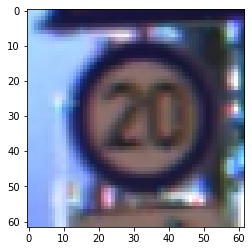

In [21]:
plt.imshow(o[0])
plt.show()

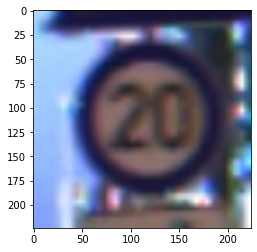

In [22]:
plt.imshow(x[0].permute(1, 2, 0))
plt.show()

# Creating the dictionary of train and validation dataset

In [23]:
dataloaders = {"train" : train_loader,
               "val" : validation_loader}

# Model initialize

In [24]:
def create_model():
    model = torchvision.models.resnet34(weights='ResNet34_Weights.DEFAULT')
    n_features = model.fc.in_features
    
    model.fc = nn.Linear(n_features, 43)

    return model.to(dml)

In [25]:
base_model = create_model()
base_model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Defining Hyperparameter

In [ ]:
num_classes = 43
num_epochs = 10
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(base_model.parameters(), lr=learning_rate)

# Training the model

In [ ]:
validation_loss = []
training_loss = []

def train_model():
    since = time.time()
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(base_model.state_dict())
    best_acc = 0.0
    
    progress_bar_train = tqdm(range(num_epochs * len(train_loader)))
    progress_bar_eval = tqdm(range(num_epochs * len(validation_loader)))
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                base_model.train()  # Set model to training mode
            else:
                base_model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, label in dataloaders[phase]:
                labels = torch.tensor([l.item() for l in label])
                inputs = inputs.to(dml)
                labels = labels.to(dml)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): 
                    outputs = base_model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        progress_bar_train.update(1)
                    elif phase == 'val':
                        progress_bar_eval.update(1)
                        
                running_loss += loss.item() * inputs.size(0)
                preds = preds.cpu()
                labels = labels.data.cpu()
                running_corrects += (preds == labels).sum()
            
            print("Lenght: ", len(dataloaders[phase].dataset))
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = float(running_corrects) / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
              training_loss.append(epoch_loss)
            elif phase == 'val':
              validation_loss.append(epoch_loss)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(base_model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    base_model.load_state_dict(best_model_wts)
    return base_model, val_acc_history

In [ ]:
best_model, validation_acc_hist = train_model()

  0%|          | 0/46650 [00:00<?, ?it/s]

  0%|          | 0/5180 [00:00<?, ?it/s]

Epoch 0/9
----------
Lenght:  37323
train Loss: 0.1813 Acc: 0.9586
Lenght:  4148
val Loss: 0.0305 Acc: 0.9923

Epoch 1/9
----------
Lenght:  37323
train Loss: 0.0438 Acc: 0.9905
Lenght:  4148
val Loss: 0.0220 Acc: 0.9949

Epoch 2/9
----------
Lenght:  37323
train Loss: 0.0281 Acc: 0.9936
Lenght:  4148
val Loss: 0.0031 Acc: 0.9983

Epoch 3/9
----------
Lenght:  37323
train Loss: 0.0251 Acc: 0.9946
Lenght:  4148
val Loss: 0.0103 Acc: 0.9964

Epoch 4/9
----------
Lenght:  37323
train Loss: 0.0179 Acc: 0.9961
Lenght:  4148
val Loss: 0.0069 Acc: 0.9971

Epoch 5/9
----------
Lenght:  37323
train Loss: 0.0169 Acc: 0.9962
Lenght:  4148
val Loss: 0.0081 Acc: 0.9976

Epoch 6/9
----------
Lenght:  37323
train Loss: 0.0153 Acc: 0.9969
Lenght:  4148
val Loss: 0.0352 Acc: 0.9872

Epoch 7/9
----------
Lenght:  37323
train Loss: 0.0119 Acc: 0.9974
Lenght:  4148
val Loss: 0.0064 Acc: 0.9978

Epoch 8/9
----------
Lenght:  37323
train Loss: 0.0106 Acc: 0.9974
Lenght:  4148
val Loss: 0.0009 Acc: 0.9988

E

# Plotting training and validation loss

In [ ]:
x = torch.linspace(0, num_epochs, num_epochs)
plt.figure(figsize=(15,5))
plt.plot(x, training_loss)
plt.plot(x, validation_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("Epoch")
plt.ylabel("Train & validation loss")
plt.show()

NameError: name 'num_epochs' is not defined

# Saving trained model to drive

In [26]:
model_path = '/content/drive/MyDrive/Uploaded/Softcom Lab/Trained models/resnet34.pt'

In [ ]:
torch.save(best_model.state_dict(), model_path)

NameError: name 'best_model' is not defined

# Run this cell only if you load directly trained model from drive

In [27]:
best_model = base_model

# Loading model from drive

In [28]:
if torch.cuda.is_available():
  best_model.load_state_dict(torch.load(model_path))
else:
  best_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Testing the model using test dataset

In [31]:
def get_predictions():
    softmax = nn.Softmax(dim=1)
    best_model.eval()
    predictions = []
    real_values = []
    pred_probas = []
    misclassified = []
    
    with torch.no_grad():
        for images, labels, original in test_loader:
            images = images.to(dml)
            labels = labels.to(dml)
            
            outputs = softmax(best_model(images))
            
            _, preds = torch.max(outputs, dim = 1)
            for probs in outputs.cpu():   
                pred_probas.append(list(probs))
            preds = preds.cpu()
            labels = labels.cpu()
            predictions.extend(preds)
            real_values.extend(labels)
            
            for ind, (actual, pred) in enumerate(zip(labels, preds)):
                if actual != pred:
                    misclassified.append(np.array(original[ind]))
            
    return predictions, real_values, pred_probas, misclassified

In [32]:
pred, real, probas, misclasses = get_predictions()
print(classification_report([y_actual.item() for y_actual in real], [y_pred.item() for y_pred in pred], target_names = class_name, digits=4))

                               precision    recall  f1-score   support

         Speed limit (20km/h)     1.0000    1.0000    1.0000        54
         Speed limit (30km/h)     1.0000    0.9966    0.9983       588
         Speed limit (50km/h)     0.9950    1.0000    0.9975       600
         Speed limit (60km/h)     1.0000    1.0000    1.0000       372
         Speed limit (70km/h)     0.9981    1.0000    0.9991       528
         Speed limit (80km/h)     1.0000    0.9940    0.9970       498
  End of speed limit (80km/h)     1.0000    1.0000    1.0000       114
        Speed limit (100km/h)     1.0000    1.0000    1.0000       378
        Speed limit (120km/h)     1.0000    1.0000    1.0000       372
                   No passing     1.0000    1.0000    1.0000       390
 No passing veh over 3.5 tons     1.0000    1.0000    1.0000       534
 Right-of-way at intersection     1.0000    1.0000    1.0000       348
                Priority road     1.0000    1.0000    1.0000       558
     

# More details score

In [33]:
def score_in_details():
  y_pred = [y.item() for y in pred]
  y_real = [y.item() for y in real]
    
  temp = []
  for i in probas:
    temp1 = []
    for j in i:
        temp1.append(j.item())
    temp.append(temp1)

  accuracy = recall_score(y_real, y_pred, average='macro')
  precision = precision_score(y_real, y_pred, average='macro')
  recall = recall_score(y_real, y_pred, average='macro')
  f1 = f1_score(y_real, y_pred, average='macro')
  roc_auc = roc_auc_score(y_real, temp, multi_class='ovr')
  mcc_score = matthews_corrcoef(y_real, y_pred);

  print(f"Accuracy: {accuracy * 100}%")
  print(f"Precision: {precision * 100}%")
  print(f"Recall: {recall * 100}%")
  print(f"F1-score: {f1 * 100}%")
  print(f"MCC-score: {mcc_score * 100}%")
  print(f"ROC AUC score: {roc_auc}")
  
  print()
  print()

  conf_matrix = confusion_matrix(y_real, y_pred)
  fig, ax = plt.subplots(figsize=(15,15))
  sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g', xticklabels=class_name, yticklabels=class_name)
  plt.title('Confusion matrix', fontsize=20)
  plt.ylabel('Actual label', fontsize=20)
  plt.xlabel('Predicted label', fontsize=20)
  plt.show()

Accuracy: 99.94416560403931%
Precision: 99.91826330646408%
Recall: 99.94416560403931%
F1-score: 99.930925475542%
MCC-score: 99.91990994181954%
ROC AUC score: 0.9999997684401012




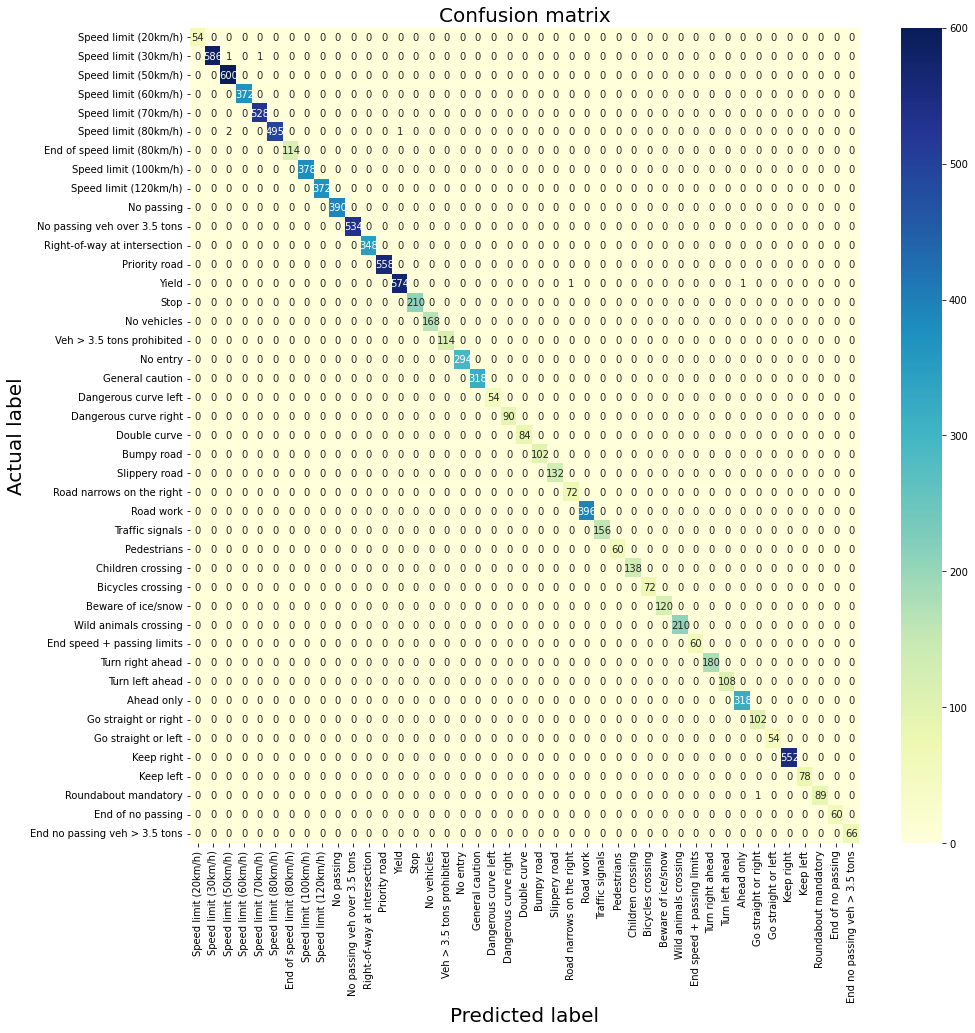

In [34]:
score_in_details()

In [ ]:
images = [np.array(img.permute(1, 2, 0).cpu()) for img in misclasses]
for no, img in enumerate(images):
    matplotlib.image.imsave(f'F:/CSE 4.2/CSE 4138 (Soft Computing Lab)/Dataset/ResNet Misclassified/img_{no + 1}.jpeg', img)